<a href="https://colab.research.google.com/github/LunguRadu/CarRecognizer/blob/main/CarRecognizer_VGG16_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# CNN for Car Recognition
### Radu and Vichy
----
In this document, you will find code snippets of different approaches we took to train CNN model on Standford car dataset.

# **Import Libraries**

We are using Tensor Flow, Keras and Pandas.

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model, clone_model
from tensorflow.keras.layers import Activation, Dense, Conv2D, MaxPool2D, Flatten, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
import matplotlib.pyplot as plt
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix, classification_report
import os
import random
from tensorflow.keras import datasets, layers, models 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import shutil
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import SGD
import pandas as pd


# **Connect to Google drive** 
This is where we store our dataset. Please provide your login code. We share the drive with you. 

In [ ]:
def mountDrive():
  from google.colab import drive
  drive.mount('/content/drive')
mountDrive()


Mounted at /content/drive


# **Data Preprocessing**

Please select ***only one*** from "flow_from_dataframe" or "flow_from_directory" and run code in that section. 

### Flow_from_dataframe

In [ ]:
# Function declaration for FLOW FROM DATAFRAME 

def create_lable_dataframe(label_path):
  """Create a label data frame from CSV file. This dataframe maps image file to categorical infomation. This dataframe will be use for creating dataset."""
  return pd.read_csv(r"{}".format(label_path))

def training_dataset_preprocess_from_dataframe(label_dataframe, train_dir_path, category_column):
  """Create training and validating dataset generators using file in directory and label from a dataframe"""
  datagen = ImageDataGenerator( 
    rotation_range=20,
    brightness_range=(-1.5, 1.5),
    fill_mode="nearest",
    cval=0.0,
    channel_shift_range=10, 
    horizontal_flip=True,
    validation_split=0.2)

  
  training = datagen.flow_from_dataframe(dataframe=label_dataframe,
                                     directory=train_dir_path,
                                     x_col="name",
                                     y_col=category_column,
                                     class_mode="categorical",
                                     target_size=(224, 224),
                                     batch_size=52,
                                     shuffle=False,
                                     subset="training",
                                     validate_filenames = True)
  validating = datagen.flow_from_dataframe(dataframe=label_dataframe,
                                     directory=train_dir_path,
                                     x_col="name",
                                     y_col=category_column,
                                     class_mode="categorical",
                                     target_size=(224, 224),
                                     batch_size=52,
                                     shuffle=False,
                                     subset= "validation",
                                     validate_filenames=True)
  return training, validating

def testing_dataset_preprocessing_from_datafram(label_dataframe, train_dir_path, category_column):
  """Create testing dataset generator using file in directory and label from a dataframe"""
  datagen = ImageDataGenerator()
  testing_set = datagen.flow_from_dataframe(dataframe=test_label_dataframe,
                                    directory=test_data_path,
                                    x_col="name",
                                    y_col=label_column,
                                    class_mode="categorical",
                                    target_size=(224, 224),
                                    batch_size=32,
                                    shuffle= False,
                                    validate_filenames = True)
  return testing_set

In [ ]:
# Declaring variable values

train_label_path = "/content/drive/Shareddrives/COMP 484 Project/label_Vichy_modified_train_data.csv"
train_data_path = '/content/drive/Shareddrives/COMP 484 Project/vichy_modified_train_data'
test_label_path = "/content/drive/Shareddrives/COMP 484 Project/label_Vichy_modified_test_data.csv"
test_data_path = "/content/drive/Shareddrives/COMP 484 Project/vichy_modified_test_data"

# Columns of .csv file to map to. This will be the label used for training. Options: "brand", "model", "body-type", "year" 
label_column = "body-type"

# training set
train_label_dataframe = create_lable_dataframe(train_label_path)
train_label_dataframe[label_column].value_counts(ascending=True)
train_generator, validate_generator = training_dataset_preprocess_from_dataframe(train_label_dataframe, train_data_path, label_column)

# testing set
test_label_dataframe = create_lable_dataframe(test_label_path)
test_generator = testing_dataset_preprocessing_from_datafram(test_label_dataframe, test_label_path, label_column)

# Number of output class: has to match the number of output nodes in the output layer of every model
nr_models = len(train_generator.class_indices)

# Looking at generator
print(nr_models)

Found 11389 validated image filenames belonging to 13 classes.
Found 2847 validated image filenames belonging to 13 classes.
Found 6151 validated image filenames belonging to 13 classes.
13


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 1 invalid image filename(s) in x_col="name". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [ ]:
print(train_generator.class_indices)
print(train_generator.classes)
print(train_generator.labels)

print(validate_generator.class_indices)
print(validate_generator.classes)
print(validate_generator.labels)

print(test_generator.class_indices)
print(test_generator.classes)
print(test_generator.labels)

{'cab': 0, 'convertible': 1, 'coupe': 2, 'hatchback': 3, 'micro': 4, 'minivan': 5, 'sedan': 6, 'ss': 7, 'supercab': 8, 'supercoupe': 9, 'suv': 10, 'van': 11, 'wagon': 12}
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 1

In [ ]:
# set Training, Validating, and Testing dataset to data from datafrom

training_dataset = train_generator
validating_dataset = validate_generator
testing_dataset = test_generator
number_classes = nr_models

### Flow_from_directory

In [ ]:
# Function that processe the data from directory 
def training_data_preprocess_from_directory(train_path):
  validating = tf.keras.preprocessing.image_dataset_from_directory(train_path,labels='inferred', 
                                                                    label_mode='categorical', 
                                                                    seed=10, 
                                                                    image_size=(224, 224),
                                                                    validation_split=0.2, 
                                                                    subset= "validation")
  training = tf.keras.preprocessing.image_dataset_from_directory(train_path, 
                                                                 labels='inferred', 
                                                                 label_mode='categorical', 
                                                                 seed=10,
                                                                 image_size=(224, 224),
                                                                 validation_split=0.2, 
                                                                 subset="training")
  return  training, validating

def testing_data_preprocess_from_directory(test_path):
  testing = tf.keras.preprocessing.image_dataset_from_directory(test_path, 
                                                                 labels='inferred', 
                                                                 label_mode='categorical', 
                                                                 seed=10,
                                                                 image_size=(224, 224))
  return testing

In [ ]:
# Declare variables for flow from directory
train_path = '/content/drive/Shareddrives/COMP 484 Project/train_new'
test_path = '/content/drive/Shareddrives/COMP 484 Project/train_new'

# training and validating set
train_batch , validate_batch = training_data_preprocess_from_directory(train_path)

# testing set
teste_batch = testing_data_preprocess_from_directory(test_path)

# number of output classes
nr_models = len(train_batch.class_names)

Found 14236 files belonging to 189 classes.
Using 2847 files for validation.
Found 14236 files belonging to 189 classes.
Using 11389 files for training.
Found 14236 files belonging to 189 classes.


In [ ]:
print(train_batch.)

In [ ]:
# set Training, Validating, and Testing dataset to data from datafrom

training_dataset = training_batch
validating_dataset = validating_batch
testing_dataset = testing_batch
number_classes = nr_models

# **Training**

### Simple Sequential Model

This to get started with training and testing data. We used this to test if data flow correct into our model

In [ ]:
def create_simple_sequential_model():
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(number_classes, activation='softmax'))
  model.summary()
  return model

In [ ]:
def plot_learning(history):
  # Show history, how training went and accuracy
  plt.plot(history.history['accuracy'], label='accuracy')
  plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.ylim([0, 1])
  plt.legend(loc='lower right')
  plt.show()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 189)               18966717  
Total params: 18,976,861
Trainable params: 18,976,861
Non-trainable params: 0
____________________________________________

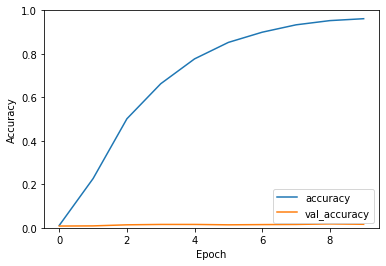

In [ ]:
# Instantiate Model
model = create_simple_sequential_model()

# Prepare model
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

# Train model
history = model.fit(training_dataset, epochs=10, validation_data=validating_dataset)

# Plot accuracy 
plot_learning(history)

#### Testing for ***flow_from_dataframe***

In [ ]:
# Testing model
Y_pred = model.predict(testing_dataset, verbose=True)
y_pred = np.argmax(Y_pred, axis=1)
print(y_pred)

# get test label

print('Confusion Matrix')
print(confusion_matrix(y_true = testing_dataset.classes, y_pred=y_pred))
print('Classification Report')
print(classification_report(testing_dataset.classes, y_pred, target_names= testing_dataset.class_indices))

193/193 [==============================] - 1530s 8s/step
[ 42 143  96 ... 127  55 126]
Confusion Matrix
[[0 2 1 ... 4 1 6]
 [1 4 0 ... 3 3 5]
 [0 5 1 ... 5 4 7]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Classification Report


ValueError: ignored

### VGG16 Original Model 

We are using the original structure of VGG 16 model and only replace the output layers. 

In [ ]:
# def create_vgg16_model(): # change names
model_vgg_16 = models.Sequential()

vgg16_model = tf.keras.applications.vgg16.VGG16()

for layer in vgg16_model.layers[:-1]:
    model_vgg_16.add(layer)

for layer in vgg16_model.layers:
    layer.trainable = False

# Add our custom output layer
model_vgg_16.add(Dense(number_classes, activation='softmax'))
print(model_vgg_16.summary())


In [ ]:
# Compile 
model_vgg_16.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

# Train
history = model_vgg_16.fit(training_dataset, epochs=20, validation_data=validating_dataset)

# Plot accuracy 
plot_learning(history)

#### Testing for ***flow_from_dataframe***

In [ ]:
# Testing model
Y_pred = model_vgg_16.predict(testing_dataset, verbose=True)
y_pred = np.argmax(Y_pred, axis=1)
print(y_pred)

# get test label
print('Confusion Matrix')
print(confusion_matrix(y_true = testing_dataset.classes, y_pred=y_pred))
print('Classification Report')
print(classification_report(testing_dataset.classes, y_pred, target_names= testing_dataset.class_indices))

### Modified VGG16 Part 1
We added the fully connected layer on top of VGG16 model while freezing all other layers underneath. 

In [ ]:
# First, we’ll load the VGG16 architecture (with pre-trained ImageNet weights) from disk, leaving off the fully connected layers. 
baseModel = VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# Define a new fully connected layer head, aka construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(512, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(number_classes, activation="softmax")(headModel)

#place the head FC model on top of the base model (this will become the actual model we will train)
fine_tune_model = Model(inputs=baseModel.input, outputs=headModel)

# freeze all of the CONV layers in the body of VGG16 to keep the features that the model already knows
for layer in baseModel.layers:
	layer.trainable = False

58892288/58889256 [==============================] - 0s 0us/step


In [ ]:
# Compiling the new fine tuned model with only chaning the fully conected layers(aka allowing the model to warm up)
opt = SGD(lr=1e-4, momentum=0.9)
fine_tune_model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

# Train
history = fine_tune_model.fit(training_dataset, epochs=50, validation_data=validating_dataset)

# Plot
plot_learning(history)

Epoch 1/50
312/312 [==============================] - 199s 639ms/step - loss: 6.7148 - accuracy: 0.2126 - val_loss: 2.3282 - val_accuracy: 0.2827
Epoch 2/50
312/312 [==============================] - 200s 641ms/step - loss: 2.4500 - accuracy: 0.2657 - val_loss: 2.4304 - val_accuracy: 0.2829
Epoch 3/50
312/312 [==============================] - 202s 649ms/step - loss: 2.4425 - accuracy: 0.2708 - val_loss: 2.4364 - val_accuracy: 0.3138
Epoch 4/50
312/312 [==============================] - 202s 647ms/step - loss: 2.3418 - accuracy: 0.2948 - val_loss: 2.2198 - val_accuracy: 0.3080
Epoch 5/50
312/312 [==============================] - 206s 662ms/step - loss: 2.3186 - accuracy: 0.2805 - val_loss: 2.1429 - val_accuracy: 0.3583
Epoch 6/50
312/312 [==============================] - 208s 665ms/step - loss: 2.2996 - accuracy: 0.2995 - val_loss: 2.0642 - val_accuracy: 0.3253
Epoch 7/50
312/312 [==============================] - 209s 670ms/step - loss: 2.3203 - accuracy: 0.3047 - val_loss: 2.4332 -

In [ ]:
# save model to the given path
fine_tune_model.save('/content/drive/Shareddrives/COMP 484 Project/model')

INFO:tensorflow:Assets written to: /content/drive/Shareddrives/COMP 484 Project/model/assets


Testing for ***flow_from_dataframe***

In [ ]:
# Testing model
Y_pred = model_vgg_16.predict(testing_dataset, verbose=True)
y_pred = np.argmax(Y_pred, axis=1)
print(y_pred)

# get test label
print('Confusion Matrix')
print(confusion_matrix(y_true = testing_dataset.classes, y_pred=y_pred))
print('Classification Report')
print(classification_report(testing_dataset.classes, y_pred, target_names= testing_dataset.class_indices))

### Modified VGG 16 Part 2

We unfreeze the last block of the convolutional layers. 

#### SGD(lr=1e-4, momentum=0.9)

In [ ]:
# Now that the head FC layers have been trained/initialized, lets unfreeze the final set of CONV layers and make them trainable
def create_custom_model_2():
  fine_tune_model2 = clone_model(fine_tune_model)

  for layer in fine_tune_model2.layers[15:]:
    layer.trainable = True

  # Loop over the layers in the model and show which ones are trainable or not
  for layer in fine_tune_model2.layers:
    print("{}: {}".format(layer.name, layer.trainable))
  return fine_tune_model2


input_1: False
block1_conv1: False
block1_conv2: False
block1_pool: False
block2_conv1: False
block2_conv2: False
block2_pool: False
block3_conv1: False
block3_conv2: False
block3_conv3: False
block3_pool: False
block4_conv1: False
block4_conv2: False
block4_conv3: False
block4_pool: False
block5_conv1: True
block5_conv2: True
block5_conv3: True
block5_pool: True
flatten: True
dense: True
dropout: True
dense_1: True


In [ ]:
# Create the model
fine_tune_model2 = create_custom_model_2()

In [ ]:
# Fine-tuning both the FC layer head and the final CONV block and running the model
opt = SGD(lr=1e-4, momentum=0.9)
fine_tune_model2.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

# Train
history = fine_tune_model2.fit(training_dataset, epochs=150, validation_data=validating_dataset)

# plot
plot_learning(history)

# save 
fine_tune_model2.save('/content/drive/Shareddrives/COMP 484 Project/model2')

Epoch 1/150
312/312 [==============================] - 202s 646ms/step - loss: 0.6816 - accuracy: 0.7680 - val_loss: 1.9772 - val_accuracy: 0.4836
Epoch 2/150
312/312 [==============================] - 200s 641ms/step - loss: 0.6065 - accuracy: 0.7878 - val_loss: 1.7110 - val_accuracy: 0.5468
Epoch 3/150
312/312 [==============================] - 198s 634ms/step - loss: 0.5687 - accuracy: 0.8013 - val_loss: 2.0858 - val_accuracy: 0.4991
Epoch 4/150
312/312 [==============================] - 200s 640ms/step - loss: 0.5221 - accuracy: 0.8148 - val_loss: 1.9509 - val_accuracy: 0.5377
Epoch 5/150
312/312 [==============================] - 207s 662ms/step - loss: 0.5005 - accuracy: 0.8262 - val_loss: 1.7649 - val_accuracy: 0.5119
Epoch 6/150
312/312 [==============================] - 202s 648ms/step - loss: 0.4774 - accuracy: 0.8334 - val_loss: 1.9684 - val_accuracy: 0.5082
Epoch 7/150
312/312 [==============================] - 214s 684ms/step - loss: 0.4373 - accuracy: 0.8449 - val_loss: 1

##### Test for ***flow_from_dataframe***

In [ ]:
# Testing model
Y_pred = model_vgg_16.predict(testing_dataset, verbose=True)
y_pred = np.argmax(Y_pred, axis=1)
print(y_pred)

# get test label
print('Confusion Matrix')
print(confusion_matrix(y_true = testing_dataset.classes, y_pred=y_pred))
print('Classification Report')
print(classification_report(testing_dataset.classes, y_pred, target_names= testing_dataset.class_indices))

##### Additional Epoch
Running an additional 50 epoch to see how if the val_accuracy increase when the accuracy alread reaches 99%. 

Found 11389 validated image filenames belonging to 13 classes.
Found 2847 validated image filenames belonging to 13 classes.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 1 invalid image filename(s) in x_col="name". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 6151 validated image filenames belonging to 13 classes.
Epoch 1/50
356/356 [==============================] - 206s 580ms/step - loss: 1.0187 - accuracy: 0.6789 - val_loss: 1.4494 - val_accuracy: 0.4963
Epoch 2/50
356/356 [==============================] - 206s 578ms/step - loss: 0.8388 - accuracy: 0.7209 - val_loss: 1.7754 - val_accuracy: 0.4773
Epoch 3/50
356/356 [==============================] - 205s 577ms/step - loss: 0.7190 - accuracy: 0.7583 - val_loss: 1.4198 - val_accuracy: 0.5388
Epoch 4/50
356/356 [==============================] - 206s 578ms/step - loss: 0.6818 - accuracy: 0.7653 - val_loss: 1.6793 - val_accuracy: 0.5037
Epoch 5/50
356/356 [==============================] - 206s 577ms/step - loss: 0.6235 - accuracy: 0.7872 - val_loss: 1.6036 - val_accuracy: 0.5349
Epoch 6/50
356/356 [==============================] - 206s 578ms/step - loss: 0.5616 - accuracy: 0.8108 - val_loss: 1.4365 - val_accuracy: 0.5581
Epoch 7/50
356/356 [==============================] - 206s 578

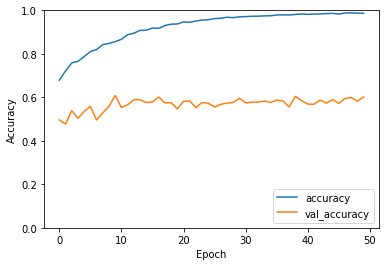

In [ ]:
# Fine-tuning both the FC layer head and the final CONV block and running the model
history = fine_tune_model2.fit(train_dataset, epochs=50, validation_data=validate_dataset)
fine_tune_model2.save('/content/drive/Shareddrives/COMP 484 Project/model2')

# Show history, how training went and accuracy
plot_learning(history)

In [ ]:
# save the updated model
fine_tune_model2.save('/content/drive/Shareddrives/COMP 484 Project/model2')

INFO:tensorflow:Assets written to: /content/drive/Shareddrives/COMP 484 Project/model2/assets


#### SGD(lr=3e-4, momentum=0.6)

In [ ]:
# Create a new untrained model similar to fine_tune_model2 
fine_tune_model3 = create_custom_model_2()

# modify the SGD optimizer
opt = SGD(lr=3e-4, momentum=0.6)

# Compile mode
fine_tune_model3.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

# train 
history = fine_tune_model3.fit(training_dataset, epochs=50, validation_data=validating_dataset)

# save model
fine_tune_model3.save('/content/drive/Shareddrives/COMP 484 Project/model3')

# Show history, how training went and accuracy
plt_learn(history)


Epoch 1/30
219/219 [==============================] - 5560s 25s/step - loss: 1.6460 - accuracy: 0.4473 - val_loss: 1.9371 - val_accuracy: 0.4331
Epoch 2/30
219/219 [==============================] - 273s 1s/step - loss: 1.5597 - accuracy: 0.4739 - val_loss: 1.7565 - val_accuracy: 0.4247
Epoch 3/30
219/219 [==============================] - 272s 1s/step - loss: 1.6033 - accuracy: 0.4569 - val_loss: 1.9424 - val_accuracy: 0.2557
Epoch 4/30
219/219 [==============================] - 273s 1s/step - loss: 1.5754 - accuracy: 0.4508 - val_loss: 1.8294 - val_accuracy: 0.4264
Epoch 5/30
219/219 [==============================] - 272s 1s/step - loss: 1.4697 - accuracy: 0.4861 - val_loss: 1.8063 - val_accuracy: 0.4380
Epoch 6/30
219/219 [==============================] - 273s 1s/step - loss: 1.5647 - accuracy: 0.4591 - val_loss: 1.9505 - val_accuracy: 0.2532
Epoch 7/30
219/219 [==============================] - 274s 1s/step - loss: 1.4973 - accuracy: 0.4757 - val_loss: 1.8866 - val_accuracy: 0.42

AttributeError: ignored

##### Testing for ***flow_from_dataframe***

In [ ]:
# Testing model
Y_pred = model_vgg_16.predict(testing_dataset, verbose=True)
y_pred = np.argmax(Y_pred, axis=1)
print(y_pred)

# get test label
print('Confusion Matrix')
print(confusion_matrix(y_true = testing_dataset.classes, y_pred=y_pred))
print('Classification Report')
print(classification_report(testing_dataset.classes, y_pred, target_names= testing_dataset.class_indices))

#### Adam()

In [ ]:
# Create a new untrained model similar to fine_tune_model2 
fine_tune_model4 = create_custom_model_2()

# change to Adam Optimizer
opt = Adam(
    learning_rate=0.003,
    epsilon=0.1,
    amsgrad=True)

# compile
fine_tune_model4.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

# train
history = fine_tune_model3.fit(train_generator, epochs=50, validation_data=validate_generator)

# save model
fine_tune_model4.save('/content/drive/Shareddrives/COMP 484 Project/model4')

# Plot 
plot_learning(history)

Epoch 1/30
219/219 [==============================] - 273s 1s/step - loss: 1.3208 - accuracy: 0.5329 - val_loss: 1.9053 - val_accuracy: 0.4535
Epoch 2/30
219/219 [==============================] - 272s 1s/step - loss: 1.3193 - accuracy: 0.5348 - val_loss: 1.9667 - val_accuracy: 0.4506
Epoch 3/30
219/219 [==============================] - 271s 1s/step - loss: 1.3191 - accuracy: 0.5341 - val_loss: 1.8954 - val_accuracy: 0.2979
Epoch 4/30
219/219 [==============================] - 270s 1s/step - loss: 1.3059 - accuracy: 0.5400 - val_loss: 1.9940 - val_accuracy: 0.4570
Epoch 5/30
219/219 [==============================] - 271s 1s/step - loss: 1.3153 - accuracy: 0.5363 - val_loss: 1.9864 - val_accuracy: 0.4577
Epoch 6/30
219/219 [==============================] - 271s 1s/step - loss: 1.3213 - accuracy: 0.5259 - val_loss: 2.0262 - val_accuracy: 0.4658
Epoch 7/30
219/219 [==============================] - 272s 1s/step - loss: 1.3053 - accuracy: 0.5428 - val_loss: 2.1640 - val_accuracy: 0.4696

AttributeError: ignored

##### Test for ***flow_from_dataframe***

In [ ]:
# Testing model
Y_pred = model_vgg_16.predict(testing_dataset, verbose=True)
y_pred = np.argmax(Y_pred, axis=1)
print(y_pred)

# get test label
print('Confusion Matrix')
print(confusion_matrix(y_true = testing_dataset.classes, y_pred=y_pred))
print('Classification Report')
print(classification_report(testing_dataset.classes, y_pred, target_names= testing_dataset.class_indices))